In [1]:
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
ENCODING_DICT = {
            'a': 0,
            'f': 1,
            'e': 2,
            'c': 3,
            'b': 4,
            'h': 5,
            'v': 6,
            'z': 7,
            '2': 8,
            'x': 9,
            'g': 10,
            'm': 11,
            'r': 12,
            'u': 13,
            'p': 14,
            's': 15,
            'd': 16,
            'n': 17,
            '6': 18,
            'k': 19,
            't': 20
            }

DECODING_DICT = {
            0: 'a',
            1: 'f',
            2: 'e',
            3: 'c',
            4: 'b',
            5: 'h',
            6: 'v',
            7: 'z',
            8: '2',
            9: 'x',
            10: 'g',
            11: 'm',
            12: 'r',
            13: 'u',
            14: 'p',
            15: 's',
            16: 'd',
            17: 'n',
            18: '6',
            19: 'k',
            20: 't'
            }

In [3]:
def imagepath_to_captcha(imagepath):
    return imagepath.split("_")[1].split(".")[0]

def to_onehot(captcha):
    label = np.zeros((len(captcha), len(ENCODING_DICT)))
    for index, char in enumerate(captcha):
        label[index, ENCODING_DICT[char]] = 1
    return tf.convert_to_tensor(label)

def captcha_from_onehot(tensor):
    label = []
    for index in tf.argmax(tensor, 1).numpy():
        label.append(DECODING_DICT[index])
    return "".join(label)

def load_dataset(filepath):
    filenames = os.listdir(filepath)
    x, y = [], []
    for file in filenames:
        imagepath = filepath + "/" + file
        image = tf.io.read_file(imagepath)
        image = tf.image.decode_image(image)
        pixels = tf.image.convert_image_dtype(image, tf.float32)
        # To show images: 
        # plt.imshow(tf.reshape(pixels, image.shape))
        # plt.title('Image as Pixels')
        # plt.show()
        x.append(pixels)
        captcha = imagepath_to_captcha(file).lower()
        y.append(to_onehot(captcha))
    return (tf.convert_to_tensor(x), tf.convert_to_tensor(y))


# Read input data

In [4]:
train_x, train_y = load_dataset("dataset/train")
test_x, test_y = load_dataset("dataset/test")

print("Training input shape:", train_x.shape)
print("Training output shape:", train_y.shape)
print("Testing input shape:", test_x.shape)
print("Testing output shape:", test_y.shape)

Training input shape: (8501, 50, 250, 3)
Training output shape: (8501, 6, 21)
Testing input shape: (1500, 50, 250, 3)
Testing output shape: (1500, 6, 21)


In [7]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(128, (2, 2), activation='relu', input_shape=(50, 250, 3)))
model.add(keras.layers.MaxPooling2D(2, 2))
model.add(keras.layers.Conv2D(64, (2, 2), activation='sigmoid'))
model.add(keras.layers.MaxPooling2D(2, 2))
model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
model.add(keras.layers.MaxPooling2D(2, 2))

model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(2016, activation='relu'))
# model.add(keras.layers.LeakyReLU(alpha=0.2))
# model.add(keras.layers.Dense(504, activation=keras.layers.LeakyReLU(alpha=0.1)))
model.add(keras.layers.Dense(504, activation='sigmoid'))
model.add(keras.layers.Dense(252, activation='relu'))
model.add(keras.layers.Dense(252, activation='relu'))
model.add(keras.layers.Dense(126, activation='softmax'))
model.add(keras.layers.Reshape((6, 21)))


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 49, 249, 128)      1664      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 124, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 23, 123, 64)       32832     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 11, 61, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 60, 32)        8224      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 30, 32)        

In [36]:
# ResNet50
model = keras.applications.ResNet50(
    include_top = False,
    weights = None,
input_tensor = keras.layers.Input(train_x))

TypeError: only integer scalar arrays can be converted to a scalar index

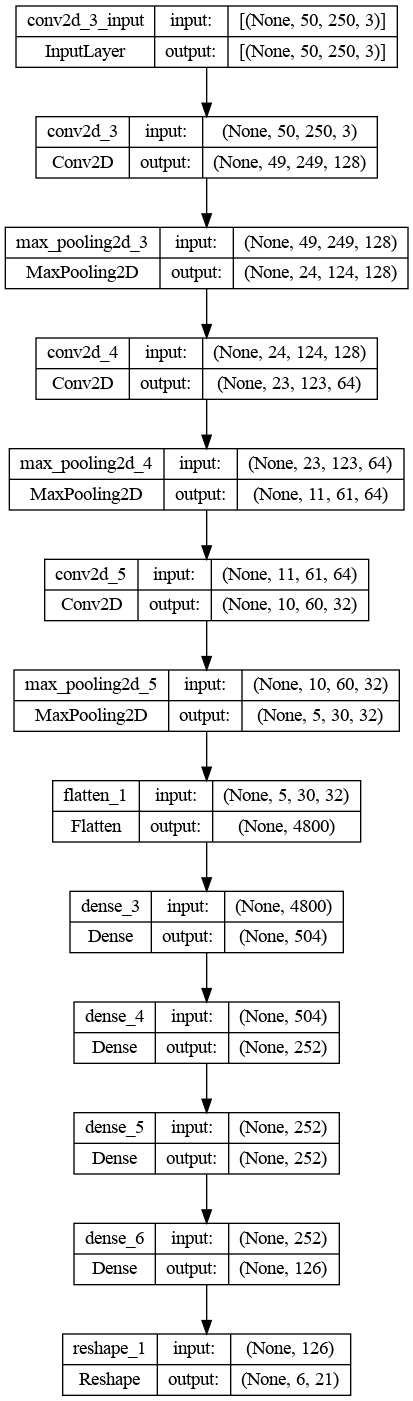

In [8]:
model.compile(
    optimizer = "adam",
    loss = 'mse',
    metrics=['accuracy']
)

tf.keras.utils.plot_model(model, show_shapes=True)


In [9]:
history = model.fit(train_x, train_y,
                    epochs = 5)

print(history.history)

Epoch 1/5
238/266 [=========================>....] - ETA: 18s - loss: 0.0469 - accuracy: 0.0490

In [42]:
model.evaluate(test_x, test_y)

47/47 [==============================] - 7s 136ms/step - loss: 0.0419 - accuracy: 0.2959


[0.04186100885272026, 0.29588890075683594]

In [48]:
model.predict(test_x)[0]
# accuracy = tf.keras.metrics.Accuracy()
# accuracy.update_state(test_y, pred_y)
# accuracy.result()

47/47 [==============================] - 6s 131ms/step


array([[1.46972834e-05, 6.75253159e-06, 7.24752899e-03, 3.34687158e-03,
        3.64864198e-03, 2.52289487e-06, 1.60639654e-04, 3.05299717e-03,
        2.75720516e-03, 3.80054582e-04, 1.09349133e-03, 4.12359841e-05,
        1.07032238e-05, 5.25581299e-06, 1.76334362e-02, 3.89554771e-04,
        1.75618843e-04, 1.67384525e-04, 1.05522154e-03, 6.23021391e-04,
        4.82913369e-04],
       [2.17074266e-05, 2.62596528e-04, 1.01464168e-04, 4.74353146e-04,
        3.34270262e-05, 1.32133018e-05, 2.61856546e-03, 7.09841773e-02,
        1.22493785e-02, 4.96132707e-05, 5.42118732e-06, 9.37243225e-04,
        9.10600356e-05, 1.81600539e-04, 6.94264090e-05, 2.64498784e-04,
        7.72038620e-05, 6.71907002e-03, 1.40106104e-05, 2.64810587e-05,
        3.95882100e-01],
       [3.20700742e-02, 4.82154283e-04, 8.14940868e-05, 9.67348169e-05,
        1.38828318e-05, 5.15618245e-04, 7.43122480e-04, 2.21284317e-05,
        7.35653739e-05, 3.72920695e-05, 2.87847488e-05, 1.93275362e-02,
        7.1779